## Import Dependencies

In [1]:
import cv2
import os 
import random
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU Growth

Avoid Out of memory error by setting GPU memory consumption

In [9]:
pip install --upgrade tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create Folder Structure

In [10]:
# SetUp paths

POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
# Make the Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH) 
os.makedirs(ANC_PATH) 

## Collecting Data

Untar Labelled Faces in the Wild Dataset

In [9]:
# Uncompress the tar file 
!tar -xf lfw.tgz

Move LFW Images to the following repository: data/negative

In [20]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect Positive and Anchor Classes

In [260]:
# Import Uuid library to generate unique image names
import uuid

In [261]:
uuid.uuid1()

UUID('abfc9792-ae47-11ef-b090-26238dae2c5d')

In [568]:
## Establish connection to webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()

    # Cut down frame to 250*250px
    frame = frame[320:320+250, 450:450+250, :]

    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)

    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)

    # Showing image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the Webcam 
cap.release()
# Close the Image show frame
cv2.destroyAllWindows()

## Data Augmentation

In [279]:
def data_aug(img):
    data = []
    for i in range(9):
        # Generate random seed values
        seed1 = np.random.randint(100)
        seed2 = np.random.randint(100)

        img = tf.image.random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=None)
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [280]:
img_path = os.path.join(ANC_PATH, '310a4980-aaff-11ef-84da-26238dae2c5d.jpg')
print(img_path)
img = cv2.imread(img_path)

augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

data/anchor/310a4980-aaff-11ef-84da-26238dae2c5d.jpg


In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## Load and Preprocess Images

### Get Image Directions

In [204]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

### Preprocessong - Scale and Resize

In [205]:
def preprocess(file_path): 
    # Read image from file path 
    byte_img = tf.io.read_file(file_path)
    # Load in the Image
    img = tf.io.decode_jpeg(byte_img)
    # Resizing the Image to be 100*100
    img = tf.image.resize(img, (100,100))
    # Scale Image between 0 and 1 
    img = img/255.0
    return img

In [206]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/10371630-aafe-11ef-84da-26238dae2c5d.jpg'


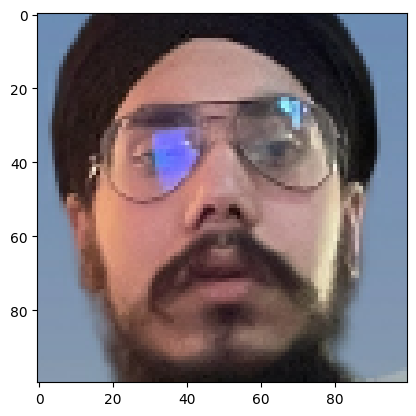

In [207]:
img = preprocess('data/anchor/8a6883b2-ad79-11ef-bd5c-26238dae2c5d.jpg')
plt.imshow(img)

### Create Labelled Dataset

In [208]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [209]:
samples = data.as_numpy_iterator()

In [210]:
example = samples.next()
print(example)

(b'data/anchor/425e605e-ad7a-11ef-bd5c-26238dae2c5d.jpg', b'data/positive/4bd2b2aa-ad7c-11ef-bd5c-26238dae2c5d.jpg', 1.0)


### Build Train and Test Partition

In [211]:
def preprocess_twin(input_img, validation_img, label): 
    return (preprocess(input_img),preprocess(validation_img), label)

In [212]:
res = preprocess_twin(*example)

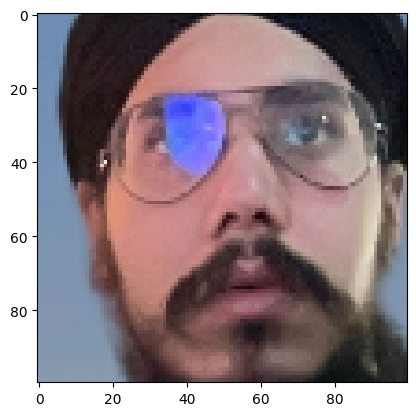

In [213]:
plt.imshow(res[0])
# plt.imshow(res[1])

### Build DataLoader Pipeline

In [214]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [215]:
samples = data.as_numpy_iterator()

In [216]:
res = samples.next()

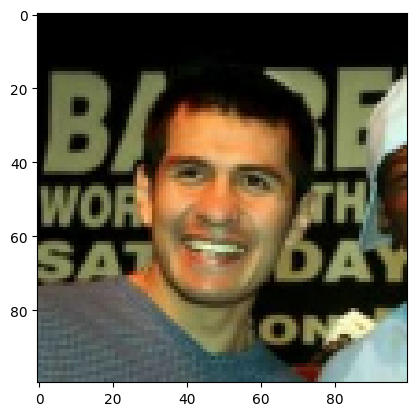

In [217]:
plt.imshow(res[1]) 

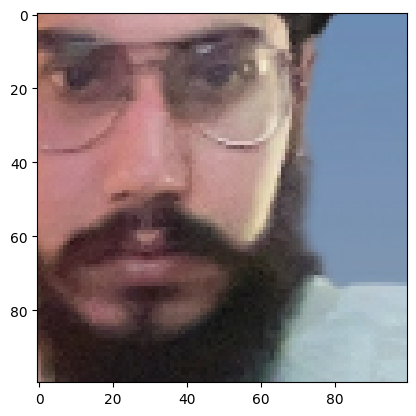

In [218]:
plt.imshow(res[0]) 

### Training Partition

In [219]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [220]:
train_samples = train_data.as_numpy_iterator()

In [221]:
train_sample = train_samples.next()

In [222]:
len(train_sample[0])

16

### Testing Partition

In [223]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [224]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
test_val

array([[[[4.27450985e-01, 5.52941203e-01, 7.05882370e-01],
         [4.27450985e-01, 5.52941203e-01, 7.05882370e-01],
         [4.27450985e-01, 5.52941203e-01, 7.05882370e-01],
         ...,
         [4.27450985e-01, 5.52941203e-01, 7.01960802e-01],
         [4.24509794e-01, 5.55882335e-01, 7.04901934e-01],
         [4.19607848e-01, 5.56862772e-01, 7.13725507e-01]],

        [[4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         [4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         [4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         ...,
         [4.26715672e-01, 5.53676486e-01, 7.02696085e-01],
         [4.25245106e-01, 5.55147052e-01, 7.01960802e-01],
         [4.24509794e-01, 5.55882335e-01, 7.04901934e-01]],

        [[4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         [4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         [4.23529416e-01, 5.56862772e-01, 7.05882370e-01],
         ...,
         [4.21568632e-01, 5.56617618e-01, 7.05637276e-01],
         [

## Model Engineering

### Build Embedding Layer

In [28]:
def make_embedding(): 
    inp = Input(shape=(100, 100, 3), name='input_image')

    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final Embedding Block 
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Build Distance Layer

In [4]:
# Siamese L1 Distance Class 

class L1Dist(Layer):
    # Init Method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # Similarity Calculation
    def call(self, input_embedding, validation_embedding): 
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

## Make Siamese Model

In [28]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [29]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [30]:
siamese_layer = L1Dist()

In [31]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor shape=(1, None, 4096), dtype=float32, sparse=False, name=keras_tensor_11>

In [20]:
distances = siamese_layer(embedding(input_image), embedding(validation_image))

In [22]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

In [32]:
def make_siamese_model(): 

    # Handle inputs
    # Anchor image input
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image input
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [33]:
siamese_model = make_siamese_model()

In [34]:
siamese_model.summary() 

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training

### Setup Loss and Optimizer

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
optimizer = tf.keras.optimizers.Adam(1e-4) # adam optimizer with 0.0001 learning rate 

### Establish Checkpoints

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

### Build Train Step Function

In [38]:
train_batch = train_data.as_numpy_iterator()

In [39]:
batch_1 = train_batch.next()

In [40]:
batch_1[2]

array([1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

The below function is designed to perform a single training step of a Siamese network using Tensorflow. This function utilizes tensorflow`s `tf.function` decorator to optimize the execution of the training loop by compiling it into a static graph for performance improvements.

In [42]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, tf.squeeze(yhat))
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Build Training Loop

While the train_step function was focused on training for one batch, the below function is focused to iterate over every batch in the dataset

In [43]:
def train(data, EPOCHS):
    # Loop through EPOCHS
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch 
        for idx, batch in enumerate(data): 
            # Run Train step here 
            train_step(batch)
            progbar.update(idx+1)

        # Save Checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [44]:
EPOCHS = 50

In [45]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image']. Received: the structure of inputs=*
  warnings.warn(
2024-11-29 09:58:06.090766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 2/50


2024-11-29 09:59:08.228530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 3/50


2024-11-29 10:00:09.738653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 4/50


2024-11-29 10:01:11.256846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 5/50


2024-11-29 10:02:12.700432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 622s 24s/step

 Epoch 6/50


2024-11-29 10:12:35.027412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 7/50


2024-11-29 10:13:38.918365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 8/50


2024-11-29 10:14:42.025752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 9/50


2024-11-29 10:15:45.155901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 10/50


2024-11-29 10:16:48.370076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step


2024-11-29 10:17:51.776673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 12/50


2024-11-29 10:18:55.520956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 13/50


2024-11-29 10:19:58.655984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 14/50


2024-11-29 10:21:01.863141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 15/50


2024-11-29 10:22:05.012158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 16/50


2024-11-29 10:23:08.172341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 17/50


2024-11-29 10:24:11.363856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 18/50


2024-11-29 10:25:14.628453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 19/50


2024-11-29 10:26:19.652213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step

 Epoch 20/50


2024-11-29 10:27:26.001744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step


2024-11-29 10:28:32.575962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step

 Epoch 22/50


2024-11-29 10:29:39.863603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 23/50


2024-11-29 10:30:47.569634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 24/50


2024-11-29 10:31:55.248052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 25/50


2024-11-29 10:33:03.093572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step

 Epoch 26/50


2024-11-29 10:34:11.915873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step

 Epoch 27/50


2024-11-29 10:35:20.724108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step

 Epoch 28/50


2024-11-29 10:36:30.214920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 Epoch 29/50


2024-11-29 10:37:40.966163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

 Epoch 30/50


2024-11-29 10:38:50.908136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step


2024-11-29 10:40:00.631153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

 Epoch 32/50


2024-11-29 10:41:11.576770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

 Epoch 33/50


2024-11-29 10:42:21.576327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

 Epoch 34/50


2024-11-29 10:43:31.332646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step

 Epoch 35/50


2024-11-29 10:45:01.996078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step

 Epoch 36/50


2024-11-29 10:46:31.819419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 37/50


2024-11-29 10:47:56.860090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step

 Epoch 38/50


2024-11-29 10:49:26.717641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step

 Epoch 39/50


2024-11-29 10:50:55.568474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step

 Epoch 40/50


2024-11-29 10:53:12.725941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step


2024-11-29 10:54:34.504110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step

 Epoch 42/50


2024-11-29 10:55:54.992264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step

 Epoch 43/50


2024-11-29 10:57:14.989865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step

 Epoch 44/50


2024-11-29 10:58:34.670819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step

 Epoch 45/50


2024-11-29 10:59:54.032699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step

 Epoch 46/50


2024-11-29 11:01:13.130255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step

 Epoch 47/50


2024-11-29 11:02:30.668347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 48/50


2024-11-29 11:03:32.076678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 960s 37s/step

 Epoch 49/50


2024-11-29 11:19:32.017822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 50/50


2024-11-29 11:20:33.508401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step


2024-11-29 11:21:34.967038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Evaluate Model

In [46]:
# Import metric calculations 
from tensorflow.keras.metrics import Precision, Recall 

In [225]:
# Get a batch of test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [226]:
test_val

array([[[[0.42745098, 0.5529412 , 0.7058824 ],
         [0.42745098, 0.5529412 , 0.7058824 ],
         [0.42745098, 0.5529412 , 0.7058824 ],
         ...,
         [0.42745098, 0.5529412 , 0.7058824 ],
         [0.42745098, 0.5529412 , 0.7058824 ],
         [0.42745098, 0.5529412 , 0.7058824 ]],

        [[0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         ...,
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ]],

        [[0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         ...,
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ],
         [0.42352942, 0.5568628 , 0.7058824 ]],

        ...,

        [[0.5323529 , 0.60294116, 0.68921566],
         [0.53161764, 0.6022059 , 0.6884804 ]

In [50]:
# Make predictions

y_hat = siamese_model.predict([test_input, test_val])
y_hat = y_hat[0]
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


array([[1.0000000e+00],
       [2.9192992e-09],
       [1.0000000e+00],
       [9.9999678e-01],
       [9.9994481e-01],
       [9.9987757e-01],
       [2.1954285e-05],
       [9.9999952e-01],
       [9.9996114e-01],
       [4.3048831e-07],
       [2.3138962e-10],
       [1.0000000e+00],
       [2.1229232e-08],
       [1.6562404e-09],
       [9.9999416e-01],
       [1.0000000e+00]], dtype=float32)

In [51]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]

In [52]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

### Calculate Metrics

In [53]:
# Creating a Metric Object 
m = Recall() 

# Calculating recall value 
m.update_state(y_true, y_hat)

# Return Recall Result 
m.result().numpy()

1.0

In [54]:
# Creating a Metric Object 
m = Precision() 

# Calculating recall value 
m.update_state(y_true, y_hat)

# Return Recall Result 
m.result().numpy()

1.0

### Visualize Results

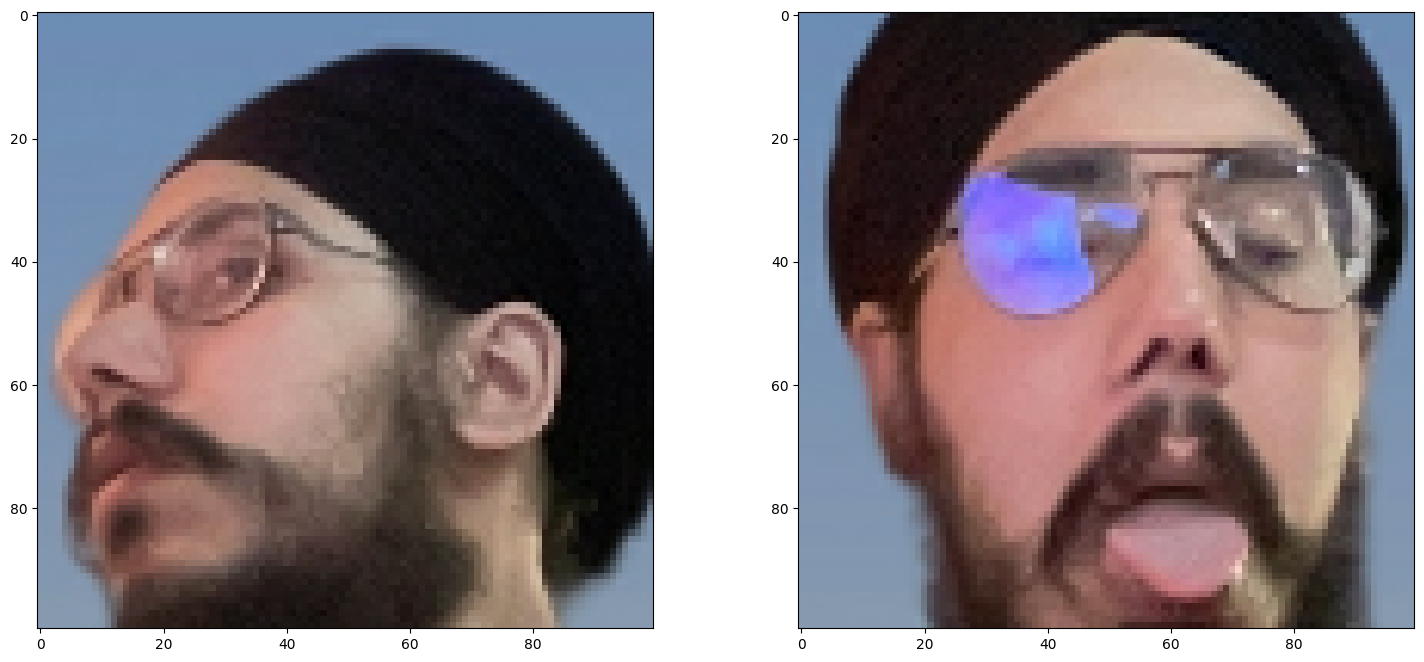

In [55]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])

## Save Model

In [65]:
# Save Weights 
siamese_model.save('siamesemodel.h5')

In [21]:
# Reload Model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [227]:
# Make predictions with loaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


2024-11-29 12:53:21.086348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


array([[[1.00000000e+00],
        [1.68681891e-11],
        [9.71120954e-01],
        [3.26332490e-08],
        [6.71682159e-08],
        [3.21600339e-07],
        [1.76776191e-10],
        [7.03111027e-07],
        [9.25722064e-13],
        [9.99998689e-01],
        [1.00000000e+00],
        [5.17515764e-06],
        [7.28033841e-01],
        [1.18986144e-07],
        [9.99981761e-01],
        [2.06319669e-07]]], dtype=float32)

In [228]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat]

NameError: name 'y_hat' is not defined

In [69]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

## Real Time Test

### Verification Function

In [229]:
os.listdir(os.path.join('application_data','verification_images'))

['602d5554-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '65cc8eda-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '0ee7f4aa-ab00-11ef-84da-26238dae2c5d.jpg',
 '6f959eba-ab00-11ef-84da-26238dae2c5d.jpg',
 '57e5aab8-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '425e605e-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '.DS_Store',
 '48cdcf24-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '9b7c90da-ad79-11ef-bd5c-26238dae2c5d.jpg',
 '61f225ea-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '664b8c4e-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '2b0c2610-ab00-11ef-84da-26238dae2c5d.jpg',
 '7e8a0eba-ab00-11ef-84da-26238dae2c5d.jpg',
 '1b37f354-ab00-11ef-84da-26238dae2c5d.jpg',
 '621aca36-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '92ab3574-ad79-11ef-bd5c-26238dae2c5d.jpg',
 '83a7d37a-ad79-11ef-bd5c-26238dae2c5d.jpg',
 '46fd9390-ab00-11ef-84da-26238dae2c5d.jpg',
 '651c12ae-ad79-11ef-bd5c-26238dae2c5d.jpg',
 '769b7ef2-ad79-11ef-bd5c-26238dae2c5d.jpg',
 '497a8994-ad7a-11ef-bd5c-26238dae2c5d.jpg',
 '08c0255c-ab00-11ef-84da-26238dae2c5d.jpg',
 '606fc844-ad7a-11ef-bd5c-26238dae2c5d.jp

In [71]:
 for image in os.listdir(os.path.join('application_data','verification_images')):
     validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
     print(validation_img)

tf.Tensor(
[[[0.42745098 0.5529412  0.7058824 ]
  [0.42745098 0.5529412  0.7058824 ]
  [0.42745098 0.5529412  0.7058824 ]
  ...
  [0.42745098 0.5529412  0.7058824 ]
  [0.42745098 0.5529412  0.7058824 ]
  [0.42745098 0.5529412  0.7058824 ]]

 [[0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  ...
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]]

 [[0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  ...
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]
  [0.42352942 0.5568628  0.7058824 ]]

 ...

 [[0.5323529  0.60294116 0.68921566]
  [0.53161764 0.6022059  0.6884804 ]
  [0.5301471  0.6007353  0.6870098 ]
  ...
  [0.53333336 0.6039216  0.6901961 ]
  [0.53333336 0.6039216  0.6901961 ]
  [0.5264706  0.59705883 0.68333334]]

 [[0.5301471  0.6007353  0.6870098 ]
  [0.5294118  0.6        0

2024-11-29 11:36:52.944018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]

In [556]:
input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
validation_img = preprocess(os.path.join('application_data', 'verification_images', '0c8adcea-ab00-11ef-84da-26238dae2c5d.jpg'))
list(np.expand_dims([input_img, validation_img], axis=1)[0][0])

[array([[0.42892158, 0.55465686, 0.6872549 ],
        [0.38063726, 0.41593137, 0.5154412 ],
        [0.2245098 , 0.19215687, 0.19313726],
        [0.23382352, 0.18284313, 0.15147059],
        [0.18651961, 0.14338236, 0.11985294],
        [0.2120098 , 0.15269607, 0.1245098 ],
        [0.24019608, 0.17352942, 0.14607844],
        [0.27916667, 0.2125    , 0.18504901],
        [0.23063725, 0.16397059, 0.13651961],
        [0.18186274, 0.11323529, 0.08676471],
        [0.2365196 , 0.1620098 , 0.1384804 ],
        [0.23161764, 0.15710784, 0.13357843],
        [0.20906863, 0.13455883, 0.11102941],
        [0.1872549 , 0.1127451 , 0.08529412],
        [0.24044117, 0.16593137, 0.1384804 ],
        [0.25833333, 0.1877451 , 0.14852941],
        [0.22107843, 0.1504902 , 0.11127451],
        [0.2634804 , 0.19093138, 0.15269607],
        [0.22794117, 0.1495098 , 0.11421569],
        [0.22965686, 0.14509805, 0.11102941],
        [0.5093137 , 0.3509804 , 0.2987745 ],
        [0.90882355, 0.7083333 , 0

In [230]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        if image.startswith('.'):
            print(f"Skipping unsupported or hidden file: {image}")
            continue
            
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### OpenCV Real Time Verification

In [232]:
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()

    # Cut down frame to 250*250px
    frame = frame[320:320+250, 450:450+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if(cv2.waitKey(10) & 0xFF == ord('v')):
        # Save Input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data','input_image', 'input_image.jpg'), frame)
        # # Run verification  
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if(cv2.waitKey(10) & 0xFF == ord('q')): 
        break

cap.release()
cv2.destroyAllWindows()

In [518]:
np.sum(np.squeeze(results) > 0.9)

0